# Exploratory Data Analysis for WATER DEMAND
- Coded by Kyungwon Joo
- AI Research Laboratory / K-water Research Institute

References
- 1_영향변수_분석.ipynb (최영돈)

용수공급량 예측을 위한 방향성에는 크게 두가지가 있음
- 각 지자체마다 개별 모델을 생성 (시계열)
- 전체 지자체를 포함하는 일반 모형 (꼭 시계열이 아니어도 됨)

# LOAD REQUIRED PACKAGES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 1.5)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="NanumGothic")

In [2]:
print('package version info.')
print(f'pandas : {pd.__version__}')
print(f'numpy : {np.__version__}')
print(f'sklearn : {sklearn.__version__}')

package version info.
pandas : 1.3.5
numpy : 1.19.5
sklearn : 0.23.2


# CASE STUDY : 서울특별시

In [3]:
CITY_NAME = '서울특별시'

## Load Dataset

### 입력자료

In [4]:
data_raw = pd.read_excel("../data/01_시군별_영향인자(독립변수)/특광역시/특별시 및 광역시 종합.xlsx", sheet_name=CITY_NAME)

In [5]:
data_raw.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
0,지역,코드,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,서울특별시,11,지역성,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,일시,계절성,NaN,NaN,NaN,NaN,NaN,NaN
2,연도,월,총인구수(명),세대수(개),세대당 인구(명),남자 인구수(명),여자 인구수(명),남여 비율(남/여),65세 이상\n고령화비율(%),전력사용량(kWh),...,기압\n평균현지기압(hPa),NaN,년월일,평균 기온(°C),일합강수량(mm),습도\n평균상대습도(%),일조량\n합계 일조시간(hr),지중온도\n평균지면온도(°C),풍량\n평균풍속(m/s),기압\n평균현지기압(hPa)
3,2001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1012.9,NaN,2001-01-01 00:00:00,-4.5,1.2,63.5,2.6,-3.7,1.7,1006.3
4,2001,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1013.3,NaN,2001-01-02 00:00:00,-4.3,NaN,59,0,-2.4,2.8,1007.9


- 3번째 index까지 data header에 해당하므로 지역명 및 지역코드만 취하고 날려줄 것
- 왼쪽과 오른쪽의 시간스텝이 다름 (왼쪽: 월, 오른쪽: 일)

In [6]:
## 왼쪽 및 오른쪽 컬럼명
data_raw.iloc[2].values

array(['연도', '월', '총인구수(명)', '세대수(개)', '세대당 인구(명)', '남자 인구수(명)',
       '여자 인구수(명)', '남여 비율(남/여)', '65세 이상\n고령화비율(%)', '전력사용량(kWh)',
       '산업체 수(개)', '산업체 규모(개)\n100인 이상 사업장', '산업단지면적(㎡)',
       '연간 가계소득\n주민1인당 자체수입액(천원)', '연간 학력수준\n고등학교 졸업(명)',
       '연간 학력수준\n고등학교 졸업자 비율\n(졸업자/만18세 인구)', '연간 인건비(천원)',
       '연간 평균 수입대비 인건비(%)', '취업률(명)\n고용보험자수', '취업률\n고용보험자 비율\n(피보험자/총인구)',
       '취약계층(개)\n장애인포함가구', '취약계층(비율)\n장애인포함가구', '평균 기온(°C)', '월합강수량(mm)',
       '습도\n평균상대습도(%)', '일조량\n합계 일조시간(hr)', '지중온도\n평균지면온도(°C)',
       '풍량\n평균풍속(m/s)', '기압\n평균현지기압(hPa)', nan, '년월일', '평균 기온(°C)',
       '일합강수량(mm)', '습도\n평균상대습도(%)', '일조량\n합계 일조시간(hr)',
       '지중온도\n평균지면온도(°C)', '풍량\n평균풍속(m/s)', '기압\n평균현지기압(hPa)'],
      dtype=object)

- 일단위 자료는 '기온', '일강수량', '습도', '일조량', '지중온도', '풍량', '기압' 등으로 월간 자료에도 포함되어 있음
> 일단위 자료는 제거하고 수행

In [7]:
CITY_CODE = data_raw.iloc[1, 1]

In [8]:
data = data_raw.iloc[3:, :29] # header 및 일단위자료 삭제
data.columns = data_raw.iloc[2, :29] # set column names

In [9]:
data.head(3)

2,연도,월,총인구수(명),세대수(개),세대당 인구(명),남자 인구수(명),여자 인구수(명),남여 비율(남/여),65세 이상\n고령화비율(%),전력사용량(kWh),...,취업률\n고용보험자 비율\n(피보험자/총인구),취약계층(개)\n장애인포함가구,취약계층(비율)\n장애인포함가구,평균 기온(°C),월합강수량(mm),습도\n평균상대습도(%),일조량\n합계 일조시간(hr),지중온도\n평균지면온도(°C),풍량\n평균풍속(m/s),기압\n평균현지기압(hPa)
3,2001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.1,39.4,62,97,-3.6,2.2,1012.9
4,2001,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.3,45.7,60,117,-0.2,2.1,1013.3
5,2001,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5,18.1,51,151,5.4,2.8,1004.8


### 출력자료 (종속변수)

In [10]:
data_y = pd.read_excel("../data/01_(종합)종속변수 데이터.xlsx", sheet_name="종합(도별 정렬)", header=1)
data_y.set_index("지자체명", inplace=True)
data_y = data_y.iloc[1:, 1:2]
data_y.rename(columns = {CITY_NAME:f'물공급량\n({CITY_NAME})'}, inplace = True)
data_y = data_y.astype(float)

## Set Index and Datatype
- 일단위 자료 때문에 발생했던 자료 길이 수정
- 컬럼명 간소화 및 dtype 변경

In [11]:
data_len = data['연도'].isna().argmax()
data = data[:data_len]

In [12]:
data.index = pd.to_datetime(data['연도'][:data_len].astype(str) + '-' + data['월'][:data_len].astype(str))
data.rename_axis(columns='', inplace=True)
data.drop(columns=['연도', '월'], inplace=True)

In [13]:
data_y.index = pd.to_datetime(data_y.index)
data_y.index.name = ""

In [14]:
# Simplify Column names
data.columns = ['총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율', '전력사용량', '산업체 수', '100인 이상 사업장', '산업단지면적', '연간 가계소득',
                '연간 고등학교 졸업(명)', '연간 고등학교 졸업자 비율', '연간 인건비', '연간 평균 수입대비 인건비', '취업률(명)', '고용보험자 비율', '취약계층(개)', '취약계층(비율)',
                '기온', '월강수량', '습도', '일조량', '지중온도', '풍량', '기압']

In [15]:
# Change datatype from object to float
data = data.astype(float)

In [16]:
data.describe()

,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,전력사용량,산업체 수,100인 이상 사업장,...,고용보험자 비율,취약계층(개),취약계층(비율),기온,월강수량,습도,일조량,지중온도,풍량,기압
count,1.680000e+02,1.680000e+02,168.000000,1.680000e+02,1.680000e+02,168.000000,168.000000,2.400000e+02,180.000000,180.000000,...,168.000000,108.000000,108.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.001952e+07,4.217975e+06,2.377514,4.931634e+06,5.087883e+06,0.969089,12.169048,3.770575e+09,416768.422222,4979.488889,...,0.388216,62932.055556,0.014742,12.933730,116.784921,60.769841,179.157540,14.238492,2.347222,1005.948016
std,2.253997e+05,9.234473e+04,0.099652,1.439320e+05,8.195161e+04,0.013110,2.460051,4.371923e+08,66031.811597,386.217490,...,0.046792,9942.913696,0.002025,9.969636,166.437911,8.422757,49.733184,10.780789,0.420340,6.440902
min,9.509458e+06,4.054493e+06,2.148541,4.618040e+06,4.891418e+06,0.944111,8.300000,2.844225e+09,316963.000000,4076.000000,...,0.306588,51014.000000,0.012209,-7.200000,0.000000,43.000000,34.300000,-4.700000,1.000000,994.700000
25%,9.812171e+06,4.182342e+06,2.313056,4.801640e+06,5.010531e+06,0.958310,9.975000,3.441126e+09,346211.000000,4594.250000,...,0.345738,53109.750000,0.012647,3.900000,24.475000,55.000000,153.000000,3.800000,2.100000,999.475000
50%,1.010486e+07,4.195255e+06,2.408376,4.979646e+06,5.125579e+06,0.971784,12.050000,3.690878e+09,426788.500000,5147.500000,...,0.388353,59744.500000,0.014183,14.050000,56.600000,59.500000,181.500000,15.350000,2.350000,1006.550000
75%,1.020632e+07,4.242082e+06,2.443871,5.062162e+06,5.150921e+06,0.981169,14.125000,4.093453e+09,476176.250000,5298.500000,...,0.430562,71032.000000,0.016468,22.250000,138.775000,66.250000,210.075000,24.625000,2.600000,1011.725000
max,1.032892e+07,4.427814e+06,2.516136,5.120401e+06,5.208514e+06,0.986706,16.800000,5.394746e+09,527480.000000,5455.000000,...,0.471206,83072.000000,0.018769,28.800000,1131.000000,85.000000,314.000000,31.900000,3.500000,1016.800000


In [17]:
data.tail(5)

,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,전력사용량,산업체 수,100인 이상 사업장,...,고용보험자 비율,취약계층(개),취약계층(비율),기온,월강수량,습도,일조량,지중온도,풍량,기압
2021-08-01,9550227.0,4416816.0,2.162242,4640740.0,4909487.0,0.945260,16.5,5.103868e+09,518938.0,5260.0,...,0.464023,81990.0,0.018563,25.9,211.2,74.0,127.3,28.2,2.1,998.6
2021-09-01,9542256.0,4421143.0,2.158323,4636069.0,4906187.0,0.944943,16.6,4.145083e+09,509936.0,5260.0,...,0.466638,82119.0,0.018574,22.6,131.0,71.0,182.0,24.6,2.3,1003.4
2021-10-01,9532428.0,4422587.0,2.155396,4630630.0,4901798.0,0.944680,16.7,3.578614e+09,520056.0,5266.0,...,0.469176,82328.0,0.018615,15.6,57.0,70.0,168.4,16.7,2.1,1011.0
2021-11-01,9520880.0,4424222.0,2.151990,4624290.0,4896590.0,0.944390,16.7,3.537141e+09,524947.0,5267.0,...,0.471206,82647.0,0.018681,8.2,62.4,68.0,163.6,7.9,2.1,1009.1
2021-12-01,9509458.0,4426007.0,2.148541,4618040.0,4891418.0,0.944111,16.8,3.963700e+09,514131.0,5269.0,...,0.470579,83072.0,0.018769,0.6,7.9,62.0,185.4,0.8,2.3,1014.4


## Check Data Availability

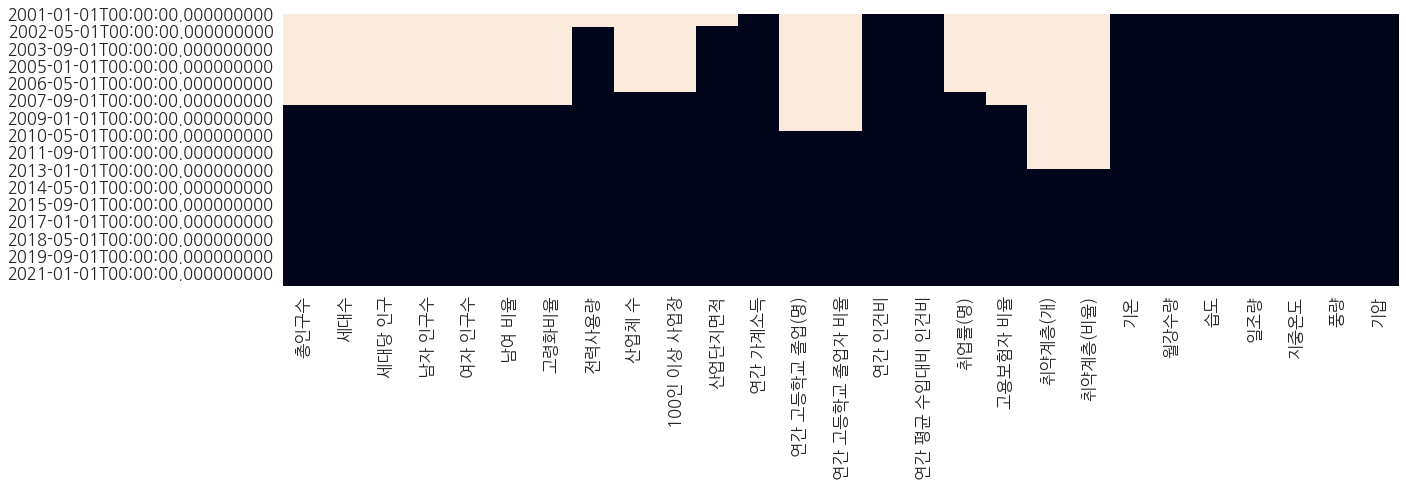

In [18]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data.isnull(), cbar=False)
plt.show()

- 데이터 시작시간이 달라 고려해야 할 부분이 좀 있음

## 수도공급량

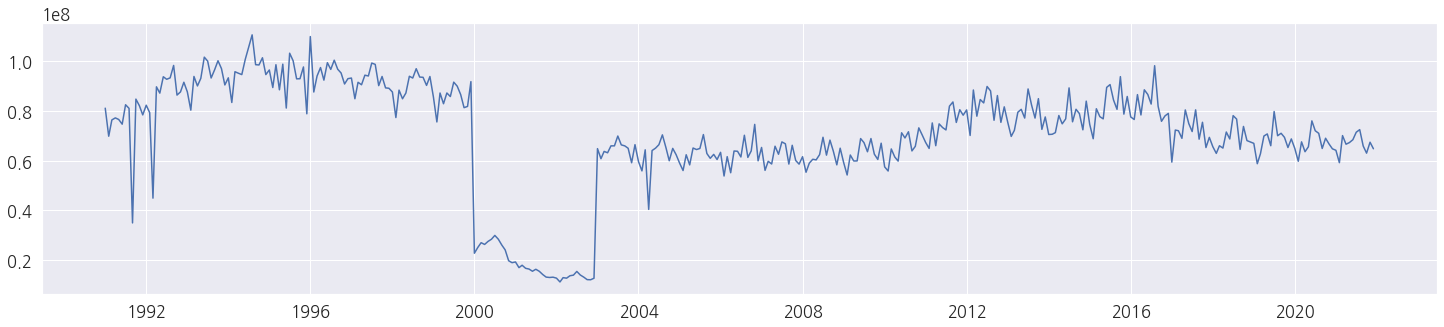

In [19]:
plt.figure(figsize=(25,5))
plt.plot(data_y)
plt.show()

- 2000~2003년은 문제가 있음
- 일단 2003년 이전은 사용하지 않는 것으로

## Set Data Range
- 가장 자료가 최근에 생성된 ```취약계층(개/비율)``` 로 세팅 (2013년~)

In [20]:
data_X = data['2013-01':]
data_y = data_y['2013-01':]
data_Xy = pd.concat([data_X, data_y], axis=1)

In [21]:
pd.concat([data_X, data_y], axis=1)

,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,전력사용량,산업체 수,100인 이상 사업장,...,취약계층(개),취약계층(비율),기온,월강수량,습도,일조량,지중온도,풍량,기압,물공급량\n(서울특별시)
2013-01-01,10195064.0,4178537.0,2.439864,5040263.0,5154801.0,0.977780,10.9,4.281117e+09,380773.0,4898.0,...,51014.0,0.012209,-3.4,22.1,57.0,167.7,-2.0,2.7,1015.3,75389372.0
2013-02-01,10196434.0,4181574.0,2.438420,5039921.0,5156513.0,0.977389,11.0,4.023566e+09,385191.0,4883.0,...,51097.0,0.012220,-1.2,74.1,54.0,187.2,0.4,2.9,1014.2,69701347.0
2013-03-01,10192057.0,4182314.0,2.436942,5037288.0,5154769.0,0.977209,11.0,3.592926e+09,390692.0,5147.0,...,51279.0,0.012261,5.1,27.3,49.0,256.3,7.0,3.0,1007.3,72139881.0
2013-04-01,10185955.0,4182017.0,2.435656,5033615.0,5152340.0,0.976957,11.1,3.512071e+09,390556.0,5142.0,...,51373.0,0.012284,10.0,71.7,54.0,213.2,11.5,3.4,1002.6,79432696.0
2013-05-01,10181807.0,4181819.0,2.434779,5030777.0,5151030.0,0.976655,11.1,3.324249e+09,398700.0,5174.0,...,51488.0,0.012312,18.2,132.0,58.0,238.1,20.2,2.9,1001.5,80596985.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,9550227.0,4416816.0,2.162242,4640740.0,4909487.0,0.945260,16.5,5.103868e+09,518938.0,5260.0,...,81990.0,0.018563,25.9,211.2,74.0,127.3,28.2,2.1,998.6,72429478.0
2021-09-01,9542256.0,4421143.0,2.158323,4636069.0,4906187.0,0.944943,16.6,4.145083e+09,509936.0,5260.0,...,82119.0,0.018574,22.6,131.0,71.0,182.0,24.6,2.3,1003.4,65857195.0
2021-10-01,9532428.0,4422587.0,2.155396,4630630.0,4901798.0,0.944680,16.7,3.578614e+09,520056.0,5266.0,...,82328.0,0.018615,15.6,57.0,70.0,168.4,16.7,2.1,1011.0,62968217.0
2021-11-01,9520880.0,4424222.0,2.151990,4624290.0,4896590.0,0.944390,16.7,3.537141e+09,524947.0,5267.0,...,82647.0,0.018681,8.2,62.4,68.0,163.6,7.9,2.1,1009.1,67368712.0


## Correlation
- 세 가지의 카테고리로 나누어 살펴보기 (1.계절성 / 2.지역성 / 3.사회성)

In [22]:
data_X.columns

Index(['총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율', '전력사용량',
       '산업체 수', '100인 이상 사업장', '산업단지면적', '연간 가계소득', '연간 고등학교 졸업(명)',
       '연간 고등학교 졸업자 비율', '연간 인건비', '연간 평균 수입대비 인건비', '취업률(명)', '고용보험자 비율',
       '취약계층(개)', '취약계층(비율)', '기온', '월강수량', '습도', '일조량', '지중온도', '풍량', '기압'],
      dtype='object')

In [23]:
# 1.계절성 (기온, 강수량, 습도, 일조, 지면온도, 풍속, 기압)
cols_seasonality = ['기온', '월강수량', '습도', '일조량', '지중온도', '풍량', '기압']
data_seasonality = pd.concat([data_X[cols_seasonality], data_y], axis=1)

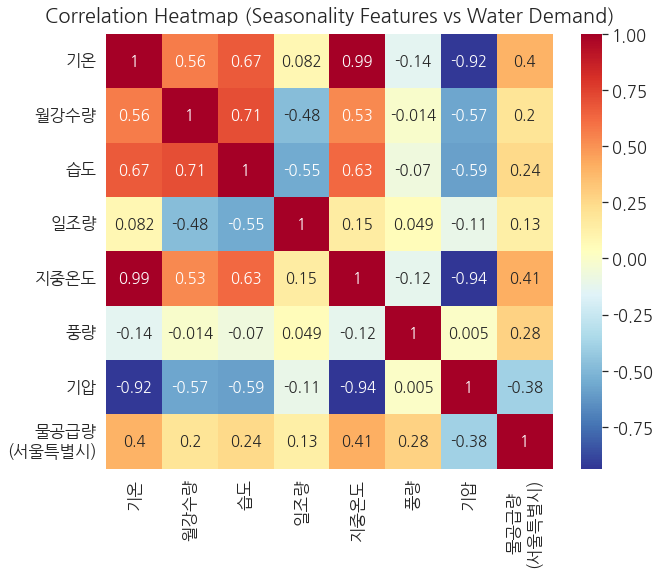

In [24]:
plt.figure(figsize=(10, 8))
data_seasonality.corr()
heatmap = sns.heatmap(data_seasonality.corr(), cmap="RdYlBu_r", annot=True, annot_kws={"fontsize":15})
heatmap.set_title('Correlation Heatmap (Seasonality Features vs Water Demand)', fontdict={'fontsize':20}, pad=12)
plt.show()

- 기온&지중온도는 0.4의 유의미한 양의 상관성
- 기압은 -0.4정도의 역상관성
- 애초에 기온과 지중온도는 0.99의 상관성을 가지며, 기압 또한 (기온, 지중온도와 -0.9의 상관성을 가짐)
    - 동일한 변수로 보아도 무방함

In [25]:
# 2.지역성 (총인구수, 세대수, 세대당 인구, 남자 인구수, 여자 인구수, 남여 비율, 고령화비율, 전력사용량, 산업체 수, 100인 이상 사업장, 산업단지면적)
cols_regional = ['총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율', '전력사용량', '산업체 수', '100인 이상 사업장', '산업단지면적']
data_regional = pd.concat([data_X[cols_regional], data_y], axis=1)

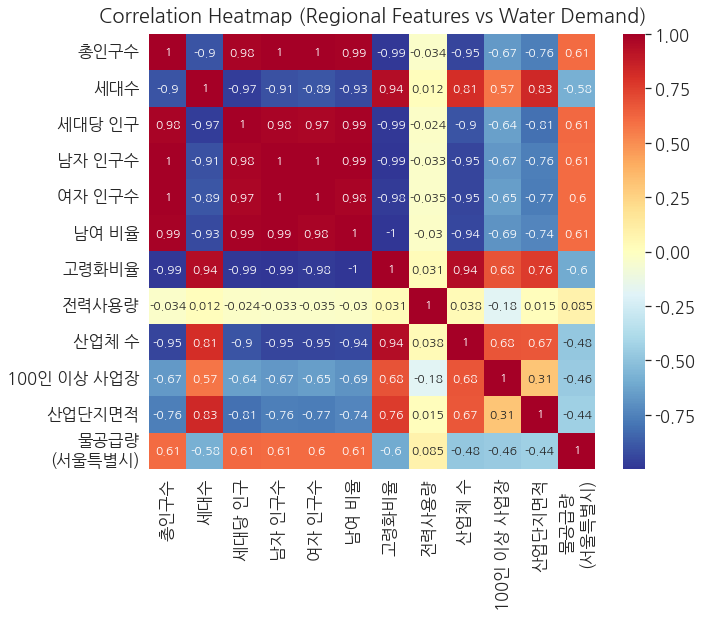

In [26]:
plt.figure(figsize=(10, 8))
data_regional.corr()
heatmap = sns.heatmap(data_regional.corr(), cmap="RdYlBu_r", annot=True, annot_kws={"fontsize":12})
heatmap.set_title('Correlation Heatmap (Regional Features vs Water Demand)', fontdict={'fontsize':20}, pad=12)
plt.show()

- 인구수(총인구, 세대당인구, 남자인구, 여자인구, 남여비율)과 0.6의 상관성 
    - 인구수는 서로 1에 가까운 상관성을 가짐 (공선성)
    - 세대수는 왜 -1에 가깝지??...
- 세대수, 고령화비율, 산업 관련3개 인자와는 -0.44 ~ -0.48의 상관성을 가짐
    - 산업체 관련 입력변수는 유사한 음의 상관성을 갖지만 서로 영향이 별로 없음

In [27]:
# 3.사회성 (연간 가계소득, 연간 고등학교 졸업(명), 연간 고등학교 졸업자 비율, 연간 인건비, 연간 평균 수입대비 인건비, 취업률(명), 고용보험자 비율, 취약계층(개), 취약계층(비율))
cols_social = ['연간 가계소득', '연간 고등학교 졸업(명)', '연간 고등학교 졸업자 비율', '연간 인건비', '연간 평균 수입대비 인건비', '취업률(명)', '고용보험자 비율', '취약계층(개)', '취약계층(비율)']
data_social = pd.concat([data_X[cols_social], data_y], axis=1)

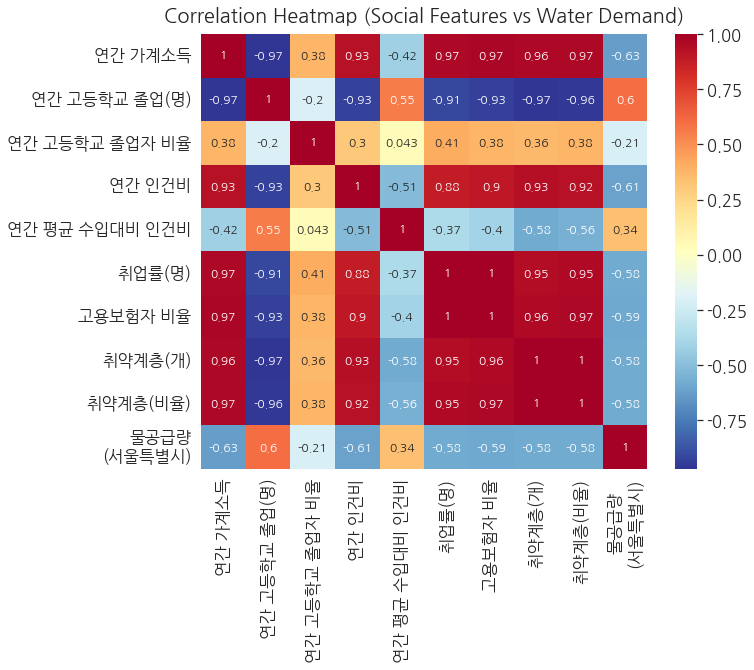

In [28]:
plt.figure(figsize=(10, 8))
data_social.corr()
heatmap = sns.heatmap(data_social.corr(), cmap="RdYlBu_r", annot=True, annot_kws={"fontsize":12})
heatmap.set_title('Correlation Heatmap (Social Features vs Water Demand)', fontdict={'fontsize':20}, pad=12)
plt.show()

In [29]:
data_corr = pd.concat([data_seasonality.corr()[-1:].T[:-1], data_regional.corr()[-1:].T[:-1], data_social.corr()[-1:].T[:-1]])
data_corr.columns = ['상관계수']
data_corr.sort_values(by='상관계수', ascending=True, inplace=True)

<AxesSubplot:>

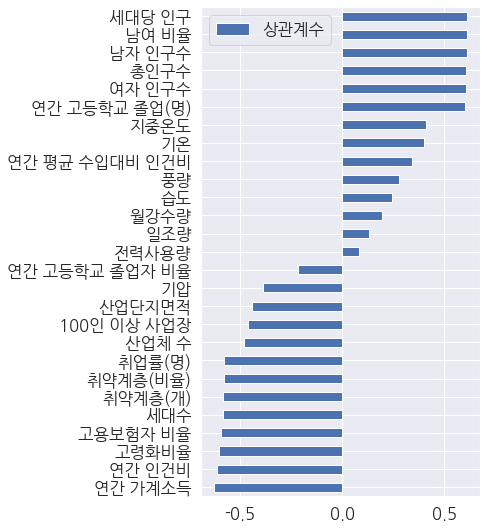

In [30]:
data_corr.plot.barh(figsize=(5,9))

## Save Cleaned Dataset

In [34]:
import os
os.mkdir('../data/02_Cleaned')

In [35]:
data_Xy.to_csv('../data/02_Cleaned/Seoul(2013-).csv')

## MODELLING
- 공선성을 띄는 변수를 제거할 수도 있지만, 일단 다 때려넣고 수행해보기로 함

### Pycaret

In [36]:
import pycaret
from pycaret.regression import *

In [37]:
data_train = data_Xy.sample(frac=0.9, random_state=42)
data_valid = data_Xy.drop(data_train.index)
data_train.reset_index(drop=True, inplace=True)
data_valid.reset_index(drop=True, inplace=True)
print(f'Data for Train: {data_train.shape}')
print(f'Data for Valid: {data_valid.shape}')

Data for Train: (97, 28)
Data for Valid: (11, 28)


In [38]:
caret_101 = setup(data = data_Xy,
                  target = '물공급량\n(서울특별시)',
                  train_size = 0.9,
                  normalize = True,
                  normalize_method = 'minmax',
                  fold = 5,
                  fold_strategy = 'timeseries',
                  remove_multicollinearity = True,
                  session_id=101)

,Description,Value
0,session_id,101
1,Target,물공급량 (서울특별시)
2,Original Data,"(108, 28)"
3,Missing Values,False
4,Numeric Features,27
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(97, 11)"


In [39]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4105310.8340,29313637667377.6758,5304889.3288,0.4817,0.0699,0.0544,0.1200
ridge,Ridge Regression,4250894.8500,29118628783718.3984,5324679.5000,0.4809,0.0708,0.0574,0.0140
rf,Random Forest Regressor,4240954.7225,29646306925887.4883,5318616.5594,0.4465,0.0710,0.0569,0.1500
ada,AdaBoost Regressor,4244134.9750,30277873419652.8906,5428555.7537,0.4461,0.0719,0.0568,0.0840
gbr,Gradient Boosting Regressor,4497010.5439,33872976647163.5469,5688405.2105,0.4177,0.0755,0.0598,0.0440
knn,K Neighbors Regressor,4671766.2000,35032141502873.6016,5830668.2000,0.3735,0.0773,0.0627,0.0140
lightgbm,Light Gradient Boosting Machine,5054729.5639,40287009841096.3125,6061212.0897,0.3214,0.0817,0.0689,0.1320
en,Elastic Net,5420949.3000,44309613956300.7969,6593173.3000,0.2286,0.0890,0.0743,0.0080
omp,Orthogonal Matching Pursuit,5065225.1887,42124345994564.4062,6372910.1524,0.1651,0.0849,0.0682,0.0060
huber,Huber Regressor,6419298.4945,58510149753773.0781,7567897.9827,-0.0105,0.1021,0.0877,0.0180


# TODOs
- Pycaret
- 

# PLAYGROUND

In [34]:
# !pip install sklearn==0.23.2